In [1]:
import warnings

warnings.filterwarnings('ignore')
import shutil
import tensorflow as tf

from heatmaps_utils import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [2]:
## GPU config
gpus = [0]
configtf = tf.ConfigProto(allow_soft_placement=True)
configtf.gpu_options.allow_growth = True
#configtf.gpu_options.visible_device_list = ','.join(str(gpu) for gpu in gpus)
init = tf.global_variables_initializer()
sess = tf.Session(config=configtf)
sess.run(init)

In [3]:
EXPERIMENT_TYPE='consistency_hyperpar_LIME_test'
# SET PROCESS TITLE
import setproctitle
setproctitle.setproctitle(EXPERIMENT_TYPE)
import sys

In [4]:
#LOAD MODEL
global model
import model_utils
reload(model_utils)
from model_utils import *
model=get_baseline_model()

In [5]:
# dowload weights at: https://doi.org/10.5281/zenodo.4312783
model.load_weights('/pannuke_baseline_IV3_100epochs/best_model.h5')

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 111, 111, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [7]:
last_conv='mixed10'

In [8]:
import os
res_folder = 'results/'
new_folder = res_folder + EXPERIMENT_TYPE
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
#shutil.copy2(src=CONFIG_FILE, dst=os.path.join(new_folder, '.'))
import h5py as hd
# DATA PATHS
cam16 = hd.File('cam16_500/patches.hdf5', 'r')
all500 = hd.File('all500/patches.hdf5', 'r')
extra17 = hd.File('extra17/patches.hdf5', 'r')
tumor_extra17=hd.File('1129-1155/patches.hdf5','r')
test2 = hd.File('test_data2/patches.hdf5','r')
pannuke= hd.File('pannuke/patches.hdf5', 'r',)
#
global data
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

# DATA SPLIT CSVs
train_csv=open('Camelyon/train_shuffle.csv', 'r')
val_csv=open('Camelyon/val_shuffle.csv', 'r')
test_csv=open('Camelyon/test_shuffle.csv', 'r')
train_list=train_csv.readlines()
val_list=val_csv.readlines()
test_list=test_csv.readlines()
test2_csv = open('Camelyon/test2_shuffle.csv', 'r')
test2_list=test2_csv.readlines()
test2_csv.close()
train_csv.close()
val_csv.close()
test_csv.close()

data_csv=open('Camelyon/pannuke/pannuke_train_shuffled.csv', 'r')
data_list=data_csv.readlines()
data_csv.close()
sys.path.append('lib/TASK_2_UC1/')
from normalizers import ReinhardNormalizer

# STAIN NORMALIZATION
def get_normalizer(patch, save_folder=''):
    normalizer = ReinhardNormalizer()
    normalizer.fit(patch)
    np.save('{}/normalizer'.format(save_folder),normalizer)
    np.save('{}/normalizing_patch'.format(save_folder), patch)
    print('Normalisers saved to disk.')
    return normalizer

def normalize_patch(patch, normalizer):
    return np.float64(normalizer.transform(np.uint8(patch)))

def get_keys(l):
    db_name=l.split(', ')[0]
    entry_path=l.split(', ')[1]
    patch_no=l.split(', ')[2]
    return db_name, entry_path, int(patch_no)

def get_class_name(entry_path):
    if 'normal' in entry_path:
        return 'normal'
    else: 
        return 'tumor'
#    return entry_path.split('/')[0]

def load_patch_mask(patch_address, patch_idx, source_fld=''):
    mask=np.zeros((224,224,4))
    patch_path=source_fld+'/{}'.format(patch_idx) 
    #import pdb; pdb.set_trace()
    try:
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei
    except:
        patch_path=source_fld+patch_address.split('/node')[0]+'/{}'.format(patch_idx)
        #print patch_path
        for nuclei_mask in os.listdir(patch_path):
            mask += plt.imread(patch_path+'/'+nuclei_mask)
        n_nuclei=len(os.listdir(patch_path))
        return mask, n_nuclei

# LOAD DATA NORMALIZER
global normalizer
db_name, entry_path, patch_no = get_keys(data_list[0])
normalization_reference_patch = data[db_name][entry_path][patch_no]
normalizer = get_normalizer(normalization_reference_patch, save_folder=new_folder)

Using brightness standardization
Normalisers saved to disk.


In [9]:
def get_cam_model_resnet101(model, last_conv_layer, pred_layer):
    n_classes = model.output_shape[-1]
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    # upgrade keras to 2.2.3 in order to use UpSampling2D with bilinear interpolation
    # x = UpSampling2D(size=(32, 32))(last_conv_output)
    x = Conv2D(filters=n_classes, kernel_size=(1, 1), name='predictions_2')(last_conv_output)

    cam_model = Model(inputs=model.input, outputs=[model.output, x])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    return cam_model

def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map

def get_cam_model_iv3(model, last_conv_layer, pred_layer):
    n_classes = model.output_shape[-1]
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])

    last_conv_output = model.get_layer(last_conv).output
    # upgrade keras to 2.2.3 in order to use UpSampling2D with bilinear interpolation
    # x = UpSampling2D(size=(32, 32))(last_conv_output)
    x = Conv2D(filters=2048, kernel_size=(1, 1), name='extra_layer1_2')(last_conv_output)
    x = Conv2D(filters=512, kernel_size=(1,1), name='extra_layer2_2')(x)
    x = Conv2D(filters=256, kernel_size=(1,1), name='extra_layer3_2')(x)
    x = Conv2D(filters=n_classes, kernel_size=(1,1), name='predictions_2')(x)
    cam_model = Model(inputs=model.input, outputs=[model.output, x])

    final_params = model.get_layer('finetuned_features1').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 2048), final_params[1])
    
    cam_model.get_layer('extra_layer1_2').set_weights(final_params)
    final_params = model.get_layer('finetuned_features2').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 512), final_params[1])
    cam_model.get_layer('extra_layer2_2').set_weights(final_params)
    final_params = model.get_layer('finetuned_features3').get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, 256), final_params[1])
    cam_model.get_layer('extra_layer3_2').set_weights(final_params)
    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, n_classes), final_params[1])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    
    return cam_model
def cam(model, img, last_conv, original_size, pred_layer=None):
    if pred_layer is None:
        pred_layer = model.layers[-1].name
    cam_model = get_cam_model_iv3(model, last_conv_layer=last_conv, pred_layer=pred_layer)
    preds, cams = cam_model.predict(img)
    class_activation_map = postprocess(preds, cams)
    return cv2.resize(class_activation_map, original_size)


In [10]:
### gradCAM ###
def gradcam(model, img, layer_name, original_size):
    """ Grad-CAM function """
    
    cls = np.argmax(model.predict(img))
    
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    # Get outputs and grads
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([img])
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    
    weights = np.mean(grads_val, axis=(0, 1)) # Passing through GlobalAveragePooling

    cam = np.dot(output, weights) # multiply
    cam = np.maximum(cam, 0)      # Passing through ReLU
    #cam /= np.max(cam)            # scale 0 to 1.0

    cam = cv2.resize(cam, original_size)
    return cam
### gradCAM++ ###
def gradcam_plus_plus(model, img, layer_name, original_size):
    """ Grad-CAM++ function """
    
    cls = np.argmax(model.predict(img))
    y_c = model.output[0, cls]
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    first = K.exp(y_c) * grads
    second = K.exp(y_c) * grads * grads
    third = K.exp(y_c) * grads * grads * grads

    gradient_function = K.function([model.input], [y_c, first, second, third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad, conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum.reshape((1, 1, conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num / alpha_denom # 0


    weights = np.maximum(conv_first_grad[0], 0.0)
    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0), axis=0) # 0
    alphas /= alpha_normalization_constant.reshape((1, 1, conv_first_grad[0].shape[2])) # NAN
    deep_linearization_weights = np.sum((weights * alphas).reshape((-1, conv_first_grad[0].shape[2])), axis=0)

    cam = np.sum(deep_linearization_weights * conv_output[0], axis=2)
    cam = np.maximum(cam, 0) # Passing through ReLU
    #cam /= np.max(cam)       # scale 0 to 1.0  

    cam = cv2.resize(cam, original_size)
    return cam

In [11]:
test_cvs_ =open('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke/test_pannuke_shuffled.csv', 'r')
test_pannuke_list=test_cvs_.readlines()
pannuke_data=[]
for d in test_pannuke_list:
    if 'pannuke' in d:
        pannuke_data.append(d)

In [12]:
train_list=pannuke_data

In [44]:
pannuke= hd.File('/mnt/nas2/results/IntermediateResults/Camelyon/pannuke_test/patches.hdf5', 'r',)
data={'cam16':cam16,'all500':all500,'extra17':extra17, 'tumor_extra17':tumor_extra17, 'test_data2': test2, 'pannuke':pannuke}

In [45]:
def binarize_mask(mask):
    return (mask>0)*1

In [46]:
def get_semantic_mask(masks):
    binary_mask={}
    for mask_type in range(6):
        binary_mask[mask_type]=binarize_mask(masks[:,:,mask_type])
    semantic_mask=np.zeros((224,224))    
    for mask_type in range(0,5):
        semantic_mask += (mask_type+1) * binary_mask[mask_type]
    #semantic_mask-=binary_mask[5]
    return semantic_mask

In [47]:
def binarize_all_masks(masks):
    binary_masks={}
    for i in range(6):
        binary_masks[i]=binarize_mask(masks[:,:,i])
    return binary_masks

In [48]:
# creating colormaps for every cell type
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
global neoplastic, inflammatory, connective, dead, epithelial
neoplastic = colors.ListedColormap(['red'])
boundaries = [-1, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 1]
norm = colors.BoundaryNorm(boundaries, neoplastic.N, clip=True)
inflammatory = colors.ListedColormap(['green'])
connective = colors.ListedColormap(['blue'])
dead = colors.ListedColormap(['fuchsia'])
epithelial = colors.ListedColormap(['orange'])


In [49]:
train_list= [#'pannuke, pannuke/fold3/509/normal/center/patch, 0, train',
             #'pannuke, pannuke/fold3/309/normal/center/patch, 0, train',
             'pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train',
             #'pannuke, pannuke/fold3/237/tumor/upper_right/patch, 0, train'
            ]

In [50]:
def compute_avg(heatmaps):
    _tmp = heatmaps['SLIC'] + heatmaps['Felzenszwalb']
    _tmp /= 2
    heatmaps['AVG'] = _tmp
    return heatmaps

In [51]:
# creating colormaps for every cell type
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors
global neoplastic, inflammatory, connective, dead, epithelial
neoplastic = colors.ListedColormap(['red'])
boundaries = [-1, -0.9, -0.6, -0.3, 0, 0.3, 0.6, 1]
norm = colors.BoundaryNorm(boundaries, neoplastic.N, clip=True)
inflammatory = colors.ListedColormap(['green'])
connective = colors.ListedColormap(['blue'])
dead = colors.ListedColormap(['fuchsia'])
epithelial = colors.ListedColormap(['orange'])


In [52]:
ssim_file=open(new_folder+'ssim_file_nfeatures.txt', 'w')

In [53]:
# Segmentation methods used to compute superpixels needed for LIME
seg_methods = {#'Quickshift':segments_quick,
               'SLIC':segments_slic,
               'Felzenszwalb':segments_fz,
              }

# Boxes size should be a divisor of input size
# Too high sizes will give too small boxes and low weights
# for computing Squaregrid (so no impact)
# They used 3/4/6/8/12/16/24 in https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6651753/
boxes_size = []#4, 7, 8, 14, 16, 28] #, 32, 56, 112, 224]
for k in boxes_size:
    assert input_size[0] % k == 0

for k in (boxes_size):
    seg_methods['boxes_{}'.format(k*k)] = k
    
# pertubed_images = []
# pertubed_images_preds = []

def predict(patches, normalizer=normalizer):
    inputs = []
    for patch in patches:
        inputs.append(normalize_patch(patch, normalizer))
    inputs = np.asarray(inputs, dtype=np.float32)
    inputs = preprocess_input(inputs)
#     pertubed_images.extend(patches)
#     pertubed_images_preds.extend(preds)
    return model.predict(inputs)    
    
import tensorflow as tf

input_size=(224,224)
heatmaps_list=[]
nb_tumor=0
nb_normal=0
nb_target=100
ssim_list=[]

#for element in train_list[:]:
element=train_list[0]
db_name, entry_path, patch_no = get_keys(element)
_type = get_class_name(entry_path)

path = element.split(',')[1].strip(' ')[:-5]
masks = data['pannuke'][path+'mask'][0]
image= data['pannuke'][path+'patch'][0]
binary_masks=binarize_all_masks(masks)
inputs = normalize_patch(image, normalizer)
inputs = np.expand_dims(inputs, axis=0)
inputs = preprocess_input(inputs)
preds = tf.sigmoid(model.predict(inputs)[0]).eval(session=tf.Session())
_heatmaps = []
#_heatmaps['path'] = element
#_heatmaps['type'] = _type
#_heatmaps['pred'] = preds
#_heatmaps['original'] = data['pannuke'][path+'patch'][0]
#_heatmaps['mask'] = binary_masks

### LIME ###
#for name, segmentation_fn in seg_methods.items():
#if name.startswith('boxes_'):
segmentation_fn = segments_slic
#k = segmentation_fn
#segmentation_fn = lambda i : segments_box(i, k, input_size)
explainer = lime_image.LimeImageExplainer()
ssim_list.append(0)

for num_samples in range(1, 3000, 50):
    explanation = explainer.explain_instance(image, predict, top_labels=1, hide_color=0,
                                             num_samples=num_samples, segmentation_fn=segmentation_fn, num_features=100)

    # Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]
    # Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)
    heatmap = np.nan_to_num(np.asarray(heatmap, dtype=float))
    _heatmaps.append(heatmap)
    if len(_heatmaps)>2:
        ssim_list.append(ssim(_heatmaps[-1], _heatmaps[-2]))
        ssim_file.write('{}\n'.format(ssim(_heatmaps[-1], _heatmaps[-2])))

#compute_avg(_heatmaps)
#compute_squaregrid(_heatmaps)

#heatmaps_list.append(_heatmaps)

#np.save(new_folder+'/LIME_heatmaps_{}tumor_{}normal_{}'.format(nb_tumor, nb_normal, nb_target), np.asarray(heatmaps_list))

100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |########################################################################|
100% |##################################

In [67]:
data_dic={}
data_dic['ssim']=[]
data_dic['num_samples']=[]
for i in range(len(ssim_list)):
    data_dic['ssim'].append(ssim_list[i])
    data_dic['num_samples'].append(i*50)

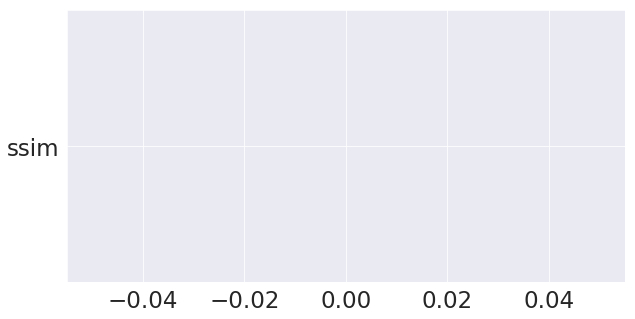

In [84]:
plt.plot(ssim_list[:])


In [86]:
ssim_list=data_dic['ssim']

TypeError: string indices must be integers, not str

In [89]:
data

,num_samples,ssim
0,0,0.000000
1,50,0.457828
2,100,0.330000
3,150,0.227203
4,200,0.488169
5,250,0.646937
6,300,0.681724
7,350,0.736881
8,400,0.752528
9,450,0.776720


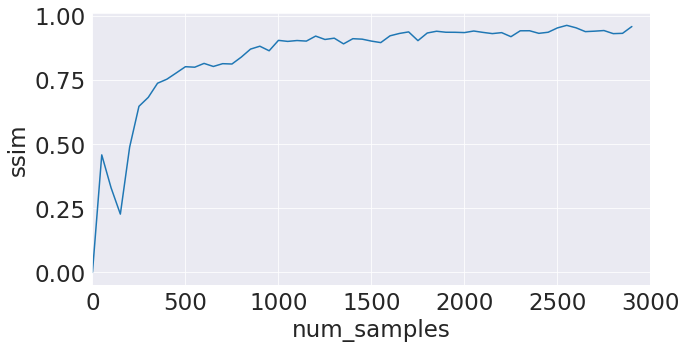

In [97]:
plt.rcParams['figure.figsize']=(10,5)
plt.rcParams['font.size']=23
import seaborn as sns
import pandas as pd
#sns.set_style("dark")
sns.set_style("darkgrid")
#data=pd.DataFrame(data_dic)
plt.xlim(0,3000)
sns.lineplot(data=data, x="num_samples", y="ssim")


In [29]:
np.save('results/ssim_vs_num_samples',ssim_list)

In [30]:
len(ssim_list)

848

pannuke/fold3/509/normal/center/


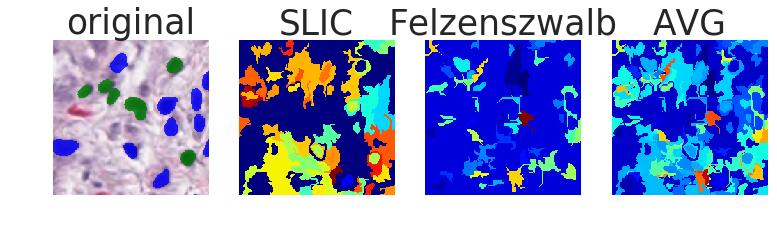

In [237]:
img_idx=0
alpha=0.8
figsize = (12.8, 4.8)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
axes[0].set_title('original', size='xx-large')
axes[1].set_title('SLIC', size='xx-large')
axes[2].set_title('Felzenszwalb', size='xx-large')
#axes[3].set_title('Quickshift', size='xx-large')
axes[3].set_title('AVG', size='xx-large')

path = heatmaps_list[img_idx]['path'].split(', ')[1][:-5]
print path
masks = data['pannuke'][path+'mask'][0]
img = np.asarray(data['pannuke'][path+'patch'][0], dtype=np.uint8)
binary_masks = binarize_all_masks(masks)

#axes[i, j].imshow(np.asarray(heatmaps[i]['original'], dtype=np.uint8))
axes[0].imshow(np.asarray(heatmaps_list[img_idx]['original'],dtype=np.uint8))
axes[0].imshow(np.ma.masked_where(binary_masks[0]==0, binary_masks[0]), alpha=alpha, cmap=neoplastic, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[1]==0, binary_masks[1]), alpha=alpha, cmap=inflammatory, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[2]==0, binary_masks[2]), alpha=alpha, cmap=connective, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[3]==0, binary_masks[3]), alpha=alpha, cmap=dead, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[4]==0, binary_masks[4]), alpha=alpha, cmap=epithelial, norm=norm)

axes[1].imshow(heatmaps_list[img_idx]['SLIC'], cmap='jet')
axes[2].imshow(heatmaps_list[img_idx]['Felzenszwalb'], cmap='jet')
axes[3].imshow(heatmaps_list[img_idx]['AVG'], cmap='jet')

for i in range(4):
    axes[i].axis('off')
plt.show()


In [29]:
for i in range(len(heatmaps_list)):
    print heatmaps_list[i]['path']

pannuke, pannuke/fold3/509/normal/center/patch, 0, train
pannuke, pannuke/fold3/309/normal/center/patch, 0, train
pannuke, pannuke/fold3/331/tumor/upper_left/patch, 0, train
pannuke, pannuke/fold3/237/tumor/upper_right/patch, 0, train


IndexError: list index out of range

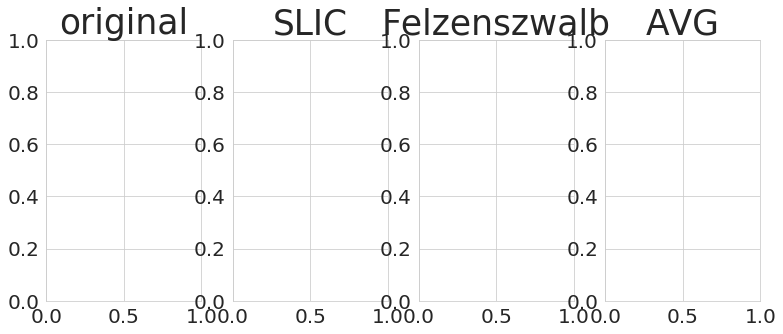

In [185]:
i=1
alpha=0.8
figsize = (12.8, 4.8)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=figsize)
axes[0].set_title('original', size='xx-large')
axes[1].set_title('SLIC', size='xx-large')
axes[2].set_title('Felzenszwalb', size='xx-large')
axes[3].set_title('AVG', size='xx-large')

path = heatmaps_list[i]['path'].split(', ')[1][:-5]
print path
masks = data['pannuke'][path+'mask'][0]
img = np.asarray(data['pannuke'][path+'patch'][0], dtype=np.uint8)
binary_masks = binarize_all_masks(masks)

#axes[i, j].imshow(np.asarray(heatmaps[i]['original'], dtype=np.uint8))
axes[0].imshow(np.asarray(heatmaps_list[i]['original'],dtype=np.uint8))
axes[0].imshow(np.ma.masked_where(binary_masks[0]==0, binary_masks[0]), alpha=alpha, cmap=neoplastic, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[1]==0, binary_masks[1]), alpha=alpha, cmap=inflammatory, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[2]==0, binary_masks[2]), alpha=alpha, cmap=connective, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[3]==0, binary_masks[3]), alpha=alpha, cmap=dead, norm=norm)
axes[0].imshow(np.ma.masked_where(binary_masks[4]==0, binary_masks[4]), alpha=alpha, cmap=epithelial, norm=norm)

axes[1].imshow(heatmaps_list[i]['SLIC'], cmap='jet')
axes[2].imshow(heatmaps_list[i]['Felzenszwalb'], cmap='jet')
axes[3].imshow(heatmaps_list[i]['AVG'], cmap='jet')
plt.show()

In [110]:
#adding nuclei_types info
image_lists={i:[] for i in range(6)}
for d in heatmaps_list:
    d['nuclei_types']=[]
idx=0
for d in heatmaps_list:
    #print d['path']
    path = d['path'].split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    #image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    binary_masks=binarize_all_masks(masks)
    for i in range(6):
        if np.sum(binary_masks[i])>0: 
            d['nuclei_types'].append(i)
    idx+=1

In [95]:
all_preds=[]
gt=[]
for d in heatmaps_list:
    print d['pred'], d['type']
    all_preds.append(d['pred'][0])
    if d['type']=='tumor':
        gt.append(1)
    else:
        gt.append(0)

[0.8684779] normal
[0.9148345] tumor
[0.9207899] normal
[0.83592004] tumor
[0.8854193] normal
[0.6879701] tumor
[0.8578568] tumor
[0.9458998] tumor
[0.83070713] normal
[0.8778393] normal
[0.9905758] tumor
[0.9261286] tumor
[0.45775872] tumor
[0.67809427] normal
[0.57439137] normal
[0.6831202] tumor
[0.49882534] normal
[0.8342596] normal
[0.61525327] normal
[0.85061157] tumor
[0.4775624] normal
[0.85541564] tumor
[0.81663597] tumor
[0.8956847] normal
[0.86331433] normal
[0.83578736] normal
[0.77380246] tumor
[0.71958] normal
[0.9411253] normal
[0.9468688] tumor
[0.88288045] tumor
[0.9135118] tumor
[0.73132414] normal
[0.8776349] tumor
[0.837148] tumor
[0.6914787] normal
[0.964907] tumor
[0.93376756] tumor
[0.7042032] tumor
[0.7180577] normal
[0.6296095] tumor
[0.93947387] tumor
[0.63505405] tumor
[0.9008359] tumor
[0.86564165] tumor
[0.94244385] tumor
[0.85344714] tumor
[0.9537834] tumor
[0.7182165] normal
[0.7210437] normal
[0.8437342] normal
[0.6759405] tumor
[0.85541564] tumor
[0.677

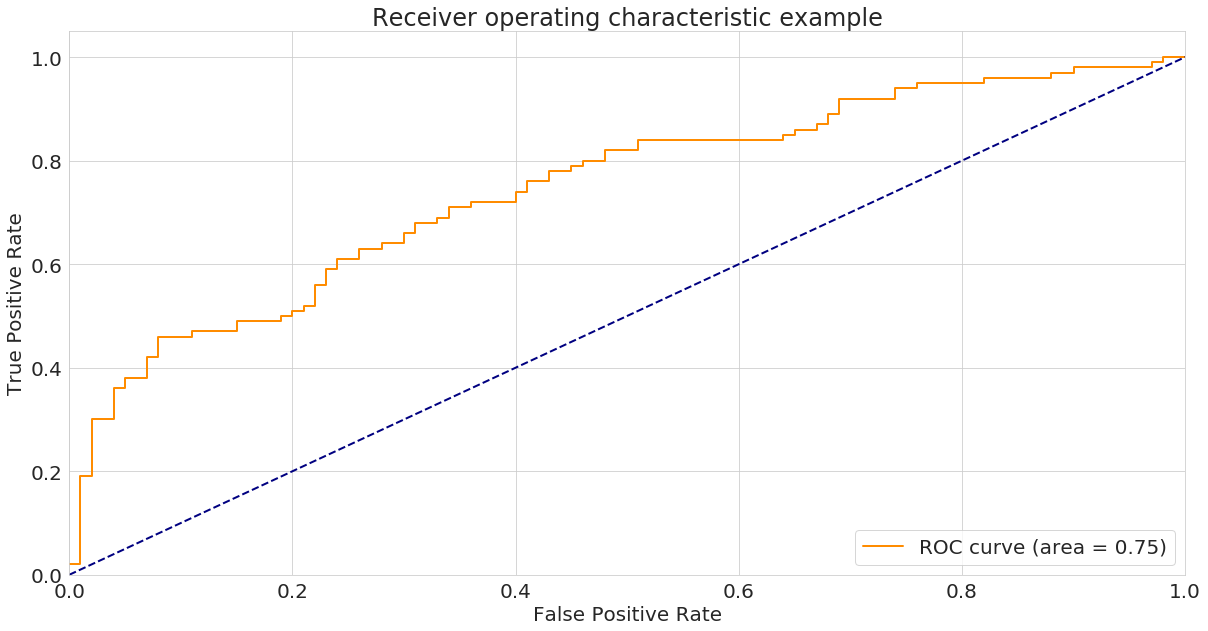

In [96]:
# AUC
import sklearn.metrics
auc=sklearn.metrics.roc_auc_score(gt,all_preds)
fpr, tpr, ths =sklearn.metrics.roc_curve(gt, all_preds)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [97]:
heatmaps_list[0]['pred']

array([0.8684779], dtype=float32)

In [98]:
for th in [0.875, 0.879, 0.88]:
    heatmaps_normal_list = [d for d in heatmaps_list if d['type'] == 'normal']
    heatmaps_tumor_list = [d for d in heatmaps_list if d['type'] == 'tumor']

    heatmaps_normal_list_pred_ok = [d for d in heatmaps_list if d['type'] == 'normal' and d['pred'] < th]
    heatmaps_tumor_list_pred_ok = [d for d in heatmaps_list if d['type'] == 'tumor' and d['pred'] >= th]
    heatmaps_normal_list_pred_ko = [d for d in heatmaps_list if d['type'] == 'normal' and d['pred'] >= th]
    heatmaps_tumor_list_pred_ko = [d for d in heatmaps_list if d['type'] == 'tumor' and d['pred'] < th]
    print th, len(heatmaps_tumor_list_pred_ok), len(heatmaps_tumor_list_pred_ko), len(heatmaps_normal_list_pred_ko),len(heatmaps_normal_list_pred_ok)
    print 'th: {}, misclassified: '.format(th), len(heatmaps_tumor_list_pred_ko)+ len(heatmaps_normal_list_pred_ko)

0.875 49 51 15 85
th: 0.875, misclassified:  66
0.879 47 53 13 87
th: 0.879, misclassified:  66
0.88 47 53 13 87
th: 0.88, misclassified:  66


In [99]:
th=0.875

In [42]:
def plot_heatmaps(data_path, heatmaps, global_colorbar=True, symmetrical_colorbar=False, cmap='RdBu', 
                  save=None, alpha=0.8, vmaxs=[1,1,1], vmins=[0,0,0], thresholds=None, show_thresholds=False, ious=True, show_text=False):
    nrows, ncols = len(heatmaps), len(heatmaps[0])
    figsize = (6.4*ncols, 4.8*nrows)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    if nrows == 1:
        axes = np.expand_dims(axes, axis=0)
    if ncols == 1:
        axes = np.expand_dims(axes, axis=1)
    methods = heatmaps[0].keys()
    methods = sorted(methods, key=lambda method: get_method_num(method))
    
    for i in range(nrows):
        for j in range(ncols):
            method = methods[j]
            axes[0, j].set_title(method, size='xx-large')
            axes[i, j].axis('off')
            if method == 'original':
                path = data_path.split(', ')[1][:-5]
                
                masks = data['pannuke'][path+'mask'][0]
                img= np.asarray(data['pannuke'][path+'patch'][0], dtype=np.uint8)
                binary_masks=binarize_all_masks(masks)
                axes[i, j].imshow(np.asarray(heatmaps[i]['original'], dtype=np.uint8))
                axes[i,j].imshow(np.ma.masked_where(binary_masks[0]==0, binary_masks[0]), alpha=alpha, cmap=neoplastic, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[1]==0, binary_masks[1]), alpha=alpha, cmap=inflammatory, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[2]==0, binary_masks[2]), alpha=alpha, cmap=connective, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[3]==0, binary_masks[3]), alpha=alpha, cmap=dead, norm=norm)
                axes[i,j].imshow(np.ma.masked_where(binary_masks[4]==0, binary_masks[4]), alpha=alpha, cmap=epithelial, norm=norm)
                if show_text:
                    axes[i, j].text(2,300, 
                                        'ORIGINAL neoplastic: {},\n inflammatory: {},\n connective: {},\n dead: {},\n epithelial: {},\n background: {}\n'.format(
                                        float(np.sum(binary_masks[0]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[1]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[2]))/(224.0*224.0),
                                         float(np.sum(binary_masks[3]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[4]))/(224.0*224.0), 
                                         float(np.sum(binary_masks[5]))/(224.0*224.0),
                                        )
                                       )
            elif method == 'mask':
                if not heatmaps[i]['mask'] is None:
                    axes[i, j].imshow(heatmaps[i]['mask'])
            else:
                if method=='CAM':
                    heatmap=normalize_heatmap(heatmaps[i]['CAM'], vmin=vmins[0], vmax=vmaxs[0])
                elif method=='gradCAM':
                    heatmap=normalize_heatmap(heatmaps[i]['gradCAM'], vmin=vmins[1], vmax=vmaxs[1])
                elif method=='gradCAM++':
                    heatmap=normalize_heatmap(clip_heatmap(heatmaps[i]['gradCAM++']), vmin=vmins[2], vmax=3)
                elif method=='CAMs':
                    heatmap=normalize_heatmap(heatmaps[i]['CAMs'], vmin=vmins[3], vmax=vmaxs[3])
                if not global_colorbar:
                    if show_thresholds:
                        im=axes[i, j].imshow(heatmap>thresholds[method], cmap='jet', vmin=0, vmax=1)
                    else:
                        im = axes[i, j].imshow(heatmap, cmap='jet', vmin=0, vmax=1)#, cmap = cmap, vmin  = vmin, vmax = vmax)
                    cax, kw = mpl.colorbar.make_axes([axes[i, j ]])
                    plt.colorbar(im, cax=cax, **kw)
                else:
                    if show_thresholds:
                        im=axes[i, j].imshow(heatmap>thresholds[method], cmap='jet', vmin=0, vmax=1)
                    else:
                        im = axes[i, j].imshow(heatmap, cmap='jet', vmin=0, vmax=1)#, cmap = cmap, vmin  = vmin, vmax = vmax)
                if ious:
                    ious_values=get_ious(data_path, heatmaps[i], thresholds)
                    if show_text:
                        axes[i, j].text(2,300, 
                                        'neoplastic: {},\n inflammatory: {},\n connective: {},\n dead: {},\n epithelial: {},\n background: {}\n'.format(
                                        ious_values[method][0], 
                                        ious_values[method][1], 
                                        ious_values[method][2],
                                        ious_values[method][3], 
                                        ious_values[method][4], 
                                        ious_values[method][5],
                                        )
                                       )              
    if global_colorbar:
        cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
        plt.colorbar(im, cax=cax, **kw)
    if not save is None:
        plt.savefig(new_folder+'/'+save+'.png')
    plt.show()

In [47]:
def normalize_heatmap(heatmap, vmin=0, vmax=1):
    if heatmap is None:
        return None
    ht = heatmap
    #h = copy.deepcopy(heatmap)
    #return (vmax-vmin)*(ht-np.min(ht))/(np.max(ht)-np.min(ht))+vmin
    return (ht-vmin)/(vmax-vmin)

In [48]:
heatmaps[0].keys()

['SLIC',
 'pred',
 'Squaregrid',
 'mask',
 'Felzenszwalb',
 'nuclei_types',
 'path',
 'AVG',
 'type',
 'original']

In [100]:
vmax_cam=0
vmax_gradcam=0
vmax_gradcamplus=0
vmax_cams=0
vmin_cam=0
vmin_gradcam=0
vmin_gradcamplus=0
vmin_cams=0
heatmaps=heatmaps_list
for v in range(len(heatmaps)):
    vmax_cam_ = np.max(heatmaps[v]['SLIC'])
    vmin_cam_=np.min(heatmaps[v]['SLIC'])
    vmax_gradcam_ = np.max(heatmaps[v]['Felzenszwalb'])
    vmin_gradcam_=np.min(heatmaps[v]['Felzenszwalb'])
    #vmax_gradcamplus_ = np.max(heatmaps[v][''])
    #vmin_gradcamplus_=np.min(heatmaps[v]['gradCAM++'])
    vmax_cams_ = np.max(heatmaps[v]['AVG'])
    vmin_cams_=np.min(heatmaps[v]['AVG'])
    if vmax_cam_>vmax_cam:
        vmax_cam=vmax_cam_
    if vmin_cam_<vmin_cam:
        vmin_cam=vmin_cam_

    if vmax_gradcam_>vmax_gradcam:
        vmax_gradcam=vmax_gradcam_
    if vmin_gradcam_<vmin_gradcam:
            vmin_gradcam=vmin_gradcam_
            
    #if vmax_gradcamplus_>vmax_gradcamplus:
    #    vmax_gradcamplus=vmax_gradcamplus_
    #if vmin_gradcamplus_<vmin_gradcamplus:
    #        vmin_gradcamplus=vmin_gradcamplus_
    if vmax_cams_>vmax_cams:
        vmax_cams=vmax_cams_
    if vmin_cams_<vmin_cams:
        vmin_cams=vmin_cams_

print vmax_cam, vmax_gradcam, vmax_cams
print vmin_cam, vmin_gradcam, vmin_cams

0.5151663239556669 0.4430193676985335 0.41493145073795923
-0.14077684110854174 -0.11763360331176471 -0.11048829096613941


In [50]:
max_=10

In [101]:
def clip_heatmap(hp):
    heat=hp
    heat[hp>5.0]=5.
    return heat

24
SLIC threshold  0.2231565715477681
22
AVG threshold  0.22
22
Felzenszwalb threshold  0.2174480238056586


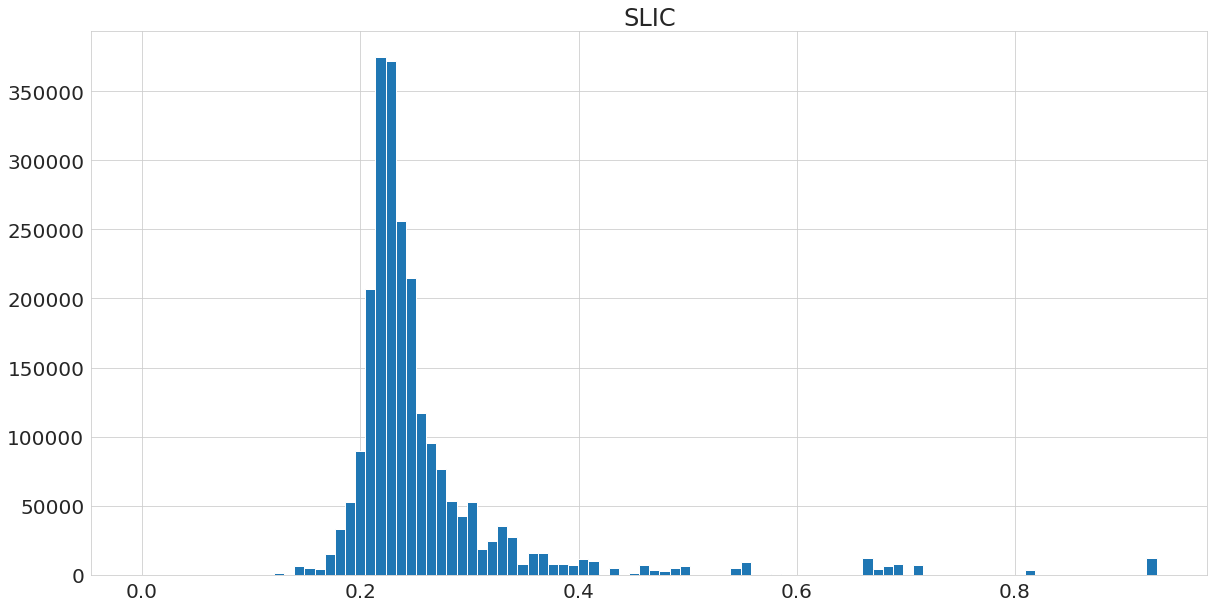

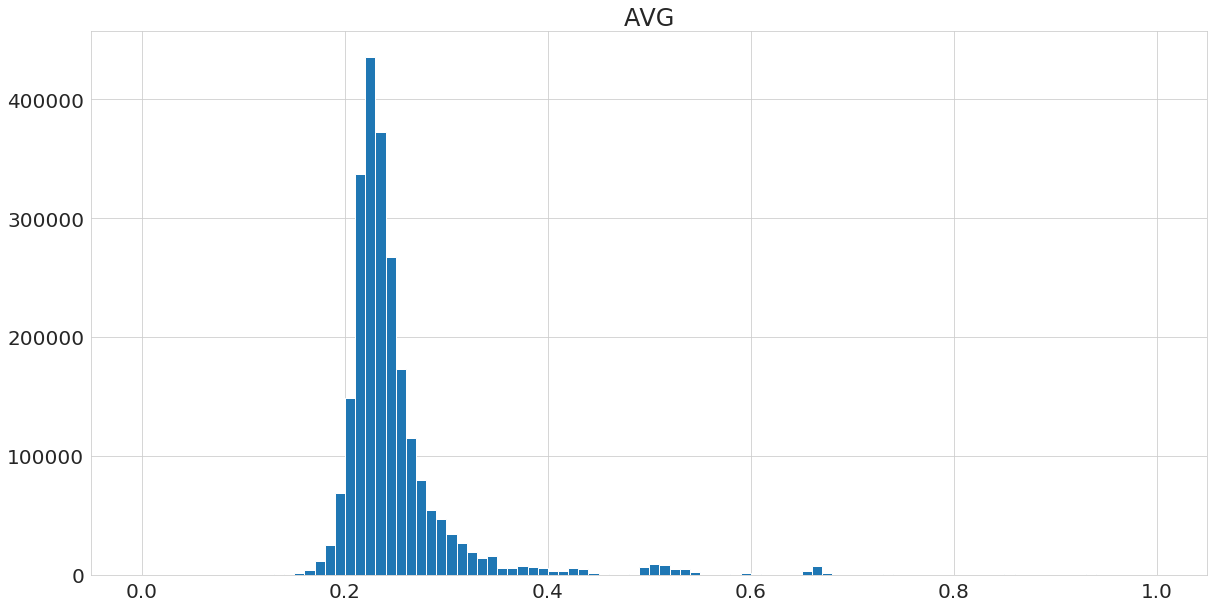

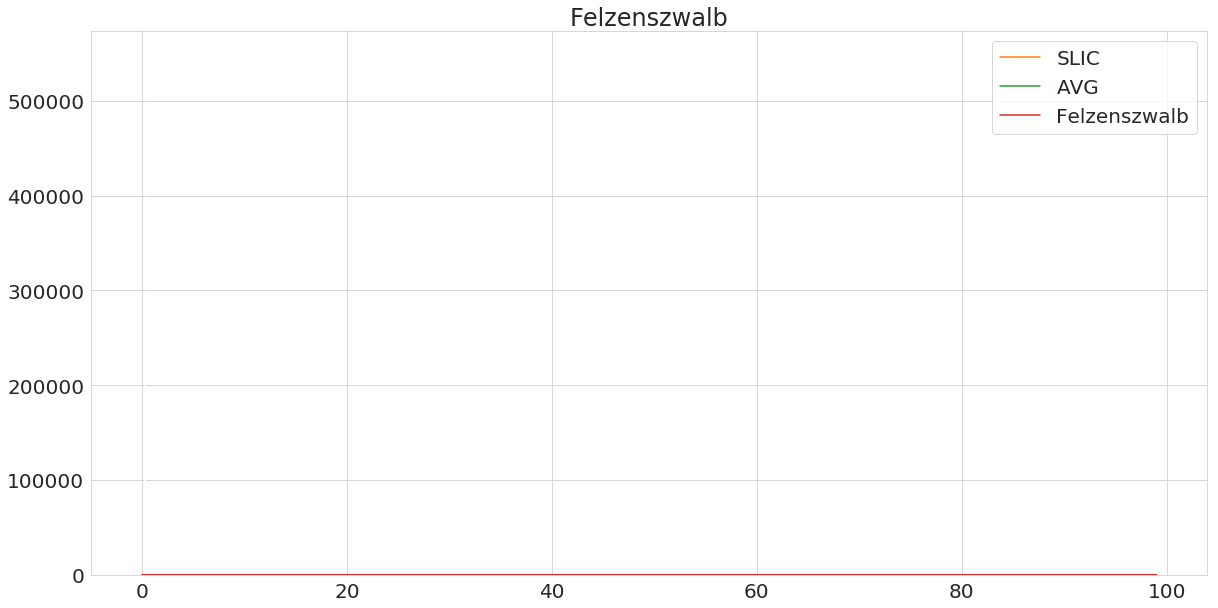

In [102]:
def find_threshold(cum, perc):
    return np.argwhere((np.asarray(cum)>perc)*1==1)[-1][0]
_h = heatmaps_tumor_list_pred_ok
methods = ['SLIC', 'AVG', 'Felzenszwalb']
concat_heat={'SLIC':[], 'AVG':[], 'Felzenszwalb': []}
tohist={}

for i in range(len(_h)):
    concat_heat['SLIC'].append(normalize_heatmap(_h[i]['SLIC'], vmin=vmin_cam, vmax=vmax_cam))
    concat_heat['Felzenszwalb'].append(normalize_heatmap(_h[i]['Felzenszwalb'], vmin=vmin_gradcam, vmax=vmax_gradcam))
    #concat_heat['gradCAM++'].append(normalize_heatmap(clip_heatmap(_h[i]['gradCAM++']), vmin=vmin_gradcamplus, vmax=5))
    concat_heat['AVG'].append(normalize_heatmap(_h[i]['AVG'], vmin=vmin_cams, vmax=vmax_cams))

tohist['SLIC'] = np.asarray(concat_heat['SLIC']).ravel()
tohist['Felzenszwalb'] = np.asarray(concat_heat['Felzenszwalb']).ravel()
#tohist['gradCAM++'] = np.asarray(concat_heat['gradCAM++']).ravel()
tohist['AVG'] = np.asarray(concat_heat['AVG']).ravel()

histograms={}

#methods = ['CAM', 'gradCAM', 'gradCAM++', 'CAMs']
for method in methods:
    plt.figure()
    #if '++' not in method:
    #histograms[method]=plt.hist(tohist[method], range=(0, np.max(tohist[method])), bins=100)
    #plt.hist(tohist[method], range=(0, np.max(tohist[method])), bins=100, cumulative=True)
    histograms[method]=plt.hist(tohist[method], range=(0, np.max(tohist[method])), bins=100)
    plt.title(method)
    #else:
    #    histograms[method]=plt.hist((tohist['gradCAM++']), range=(np.min(tohist[method]),2.9), bins=100)
    #    plt.title(method)
for method in methods:
    plt.plot([np.sum(histograms[method][0][i:])/np.sum(histograms[method][0]) for i in range(0,100)])
plt.legend(methods)   
thresholds={'SLIC':None, 'AVG':None, 'Felzenszwalb':None}
method='CAM'
for method in methods:
    cumulative_=[np.sum(histograms[method][0][i:])/np.sum(histograms[method][0]) for i in range(0,100)]
    i = find_threshold(cumulative_, 0.6)
    print i
    threshold = histograms[method][1][i]
    
    print '{} threshold '.format(method), threshold
    thresholds[method]=threshold

In [103]:
def compute_heatmap_histograms(data_path, heatmaps, vmins=[], vmaxs=[]):
    no_images, no_methods = len(heatmaps), len(heatmaps[0])
    #import pdb; pdb.set_trace()
    print no_images, no_methods
    methods = heatmaps[0].keys()
    methods = sorted(methods, key=lambda method: get_method_num(method))
    figsize = (6.4*no_methods, 4.8*no_images)
    fig, axes = plt.subplots(nrows=no_images, ncols=no_methods, figsize=figsize)
    normalized_heatmaps=[{m:d[m] for m in methods} for d in heatmaps]
    
    for j in range(no_methods):
        method=methods[j]
        axes[j].set_title(method, size='xx-large')
        
        for i in range(no_images):
            axes[j].axis('off')
            if method=='CAM':
                hp=normalized_heatmaps[i]['CAM']=normalize_heatmap(heatmaps[i]['CAM'], vmin=vmins[0], vmax=vmaxs[0])
            elif method=='gradCAM':
                hp=normalized_heatmaps[i]['gradCAM']=normalize_heatmap(heatmaps[i]['gradCAM'], vmin=vmins[1], vmax=vmaxs[1])
            elif method=='gradCAM++':
                hp=normalized_heatmaps[i]['gradCAM++']=normalize_heatmap(heatmaps[i]['gradCAM++'],vmin=vmins[2], vmax=vmaxs[2])
            if 'CAM' in method:
                #plt.figure()
                im=axes[j].hist(hp, bins=10)
    plt.savefig("results/figs/{}/{}".format(EXPERIMENT_TYPE,data_path))
    plt.show()
    
    return normalized_heatmaps

In [104]:
def get_ious(data_path, heatmap, thresholds=None):
    
    path = data_path.split(',')[1].strip(' ')[:-5]
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    methods=['CAM', 'gradCAM', 'gradCAM++', 'CAMs']
    ious={m:[] for m in methods}
    binary_masks=binarize_all_masks(masks)
    for i in range(6):
        bhp=normalize_heatmap(heatmap['CAM'], vmin=vmin_cam, vmax=vmax_cam)
        bhp=bhp>thresholds['CAM']*1
        ious['CAM'].append(iou(bhp,binary_masks[i]))
        bhp=normalize_heatmap(heatmap['gradCAM'], vmin=vmin_gradcam, vmax=vmax_gradcam)
        bhp=bhp>thresholds['gradCAM']*1
        ious['gradCAM'].append(iou(bhp,binary_masks[i]))
        bhp=normalize_heatmap(heatmap['gradCAM++'], vmin=vmin_gradcamplus, vmax=5)
        bhp=bhp>thresholds['gradCAM++']*1
        ious['gradCAM++'].append(iou(bhp,binary_masks[i]))
        bhp=normalize_heatmap(heatmap['CAMs'], vmin=vmin_cams, vmax=5)
        bhp=bhp>thresholds['CAMs']*1
        ious['CAMs'].append(iou(bhp,binary_masks[i]))
    return ious
        
def iou(bheatmap, mask):
    #import pdb; pdb.set_trace()
    epsilon=2.220446049250313e-16
    #print bheatmap+mask
    intersection=np.float32(np.sum((bheatmap+mask==2)*1))
    return intersection/(np.sum((bheatmap+mask==1)*1)+intersection+epsilon)

0


UnboundLocalError: local variable 'heatmap' referenced before assignment

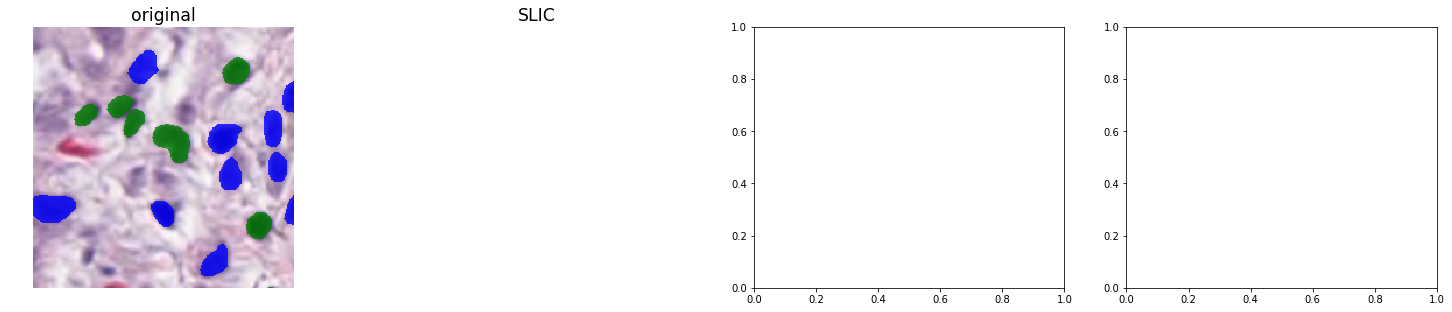

In [67]:
max_=20
configs={}
configs['global_colorbar']=True
configs['cmap']='jet'
configs['vmaxs']=[vmax_cam, vmax_gradcam, vmax_cams]
configs['vmins']=[vmin_cam, vmin_gradcam, vmin_cams]
configs['show_thresholds']=False
configs['thresholds']=thresholds
configs['ious']=True
methods = ['SLIC', 'Felzenszwalb', 'AVG']

def plot_heatmaps_list(configs, h_list):
    _h = h_list
    for i in range(len(_h)):
        h = _h[i:i+1]
        print i
        save_path=h[0]['path'].split(', ')[1].split(', ')[0].strip().replace('/', '_')
        methods = methods = ['original', 'SLIC','Felzenszwalb',  'AVG']

        path=h[0]['path']
        images=[{m:h for m,h in d.items() if m in methods} for d in h]
        
        plot_heatmaps(path, 
                      images,
                      global_colorbar=configs['global_colorbar'], 
                      cmap=configs['cmap'],
                      vmaxs=configs['vmaxs'], 
                      vmins=configs['vmins'],
                      show_thresholds=configs['show_thresholds'],
                      thresholds=configs['thresholds'],
                      ious=configs['ious'],
                      save=save_path
                     ) 
plot_heatmaps_list(configs, heatmaps_normal_list_pred_ok[:max_])
plot_heatmaps_list(configs, heatmaps_normal_list_pred_ko[:max_])
plot_heatmaps_list(configs, heatmaps_tumor_list_pred_ok[:max_])
plot_heatmaps_list(configs, heatmaps_tumor_list_pred_ko[:max_])

In [ ]:
configs['global_colorbar']

In [105]:
import pandas as pd

In [106]:
def compute_iou(bheatmap, mask):
    #import pdb; pdb.set_trace()
    epsilon=2.220446049250313e-16
    #print bheatmap+mask
    intersection=np.float32(np.sum((bheatmap+mask==2)*1))
    return intersection/(np.sum((bheatmap+mask==1)*1)+intersection+epsilon)

In [118]:
def get_iou(data_path, heatmap, method='CAM', nuclei_type=0, thresholds=None, vmins=None, vmaxs=None):
    path = data_path.split(',')[1].strip(' ')[:-5]
    #print path
    masks = data['pannuke'][path+'mask'][0]
    image= data['pannuke'][path+'patch'][0]
    #semantic_mask=get_semantic_mask(masks)
    #methods=['CAM', 'gradCAM', 'gradCAM++', 'CAMs']
    #ious={m:[] for m in methods}
    binary_masks=binarize_all_masks(masks)
    #plt.figure()
    #print nuclei_type
    #plt.imshow(binary_masks[nuclei_type])
    mask=binary_masks[nuclei_type]
    bhp=None
    #import pdb; pdb.set_trace()
    
    #method_num = 0
    if method=='SLIC':
        method_num=0
    elif method=='Felzenszwalb':
        method_num=1
        #bhp = normalize_heatmap(clip_heatmap(heatmap['gradCAM++']), vmin=vmins[method_num], vmax=5)
    elif method=='AVG':
        method_num=2  
    #print method
    #import pdb; pdb.set_trace()
    if bhp is None:
        bhp=normalize_heatmap(heatmap[method], vmin=vmins[method_num], vmax=vmaxs[method_num])
    bhp=(bhp>thresholds[method])*1
    iou_value=compute_iou(bhp, mask)
    #print iou_value
    return iou_value

max_=1
#methods=['CAM', 'gradCAM', 'gradCAM++', 'CAMs']

def get_all_iou_values(heatmaps_list, methods=methods, max_elements=100, thresholds=thresholds, configs=configs):
    ious_list={m:{i:[] for i in range(6)} for m in methods}
    nucleis_list=[]
    for h in heatmaps_list[:max_elements]:
        for m in methods:
            print m
            for i in h['nuclei_types']:
                iou_value=get_iou(h['path'], h, method=m, nuclei_type=i, thresholds=thresholds, vmins=configs['vmins'], vmaxs=configs['vmaxs'])
                ious_list[m][i].append(iou_value)
    return ious_list
                                

In [119]:
configs['vmaxs']

[0.24183956737980009, 0.11512888873867703, 0.17848422805923855]

In [120]:
ious_normal_ok = get_all_iou_values(heatmaps_normal_list_pred_ok)
ious_normal_ok = get_all_iou_values(heatmaps_normal_list_pred_ko)
ious_tumor_ok = get_all_iou_values(heatmaps_tumor_list_pred_ok)
ious_tumor_ko = get_all_iou_values(heatmaps_tumor_list_pred_ko)

SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG
SLIC
Felze

In [121]:
dic={}
#for i in range(6):
#    dic['{}'.format(i)]=[]
dic['iou']=[]
dic['nuclei_type']=[]
dic['method']=[]
dic['class']=[]

methods= ['SLIC', 'Felzenszwalb', 'AVG']

for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ok[m][k] != []:
            for el in range(len(ious_tumor_ok[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                dic['nuclei_type'].append(k)
                dic['iou'].append(ious_tumor_ok[m][k][el])
                dic['method'].append(m)
                dic['class'].append('TP')
for m in methods:
    print m
    for k in range(5):
        #print k
        if ious_tumor_ko[m][k] != []:
            for el in range(len(ious_tumor_ko[m][k])):
                #print 'nuclei_type ', k, ious_tumor_ok[m][k][el]
                dic['nuclei_type'].append(k)
                dic['iou'].append(ious_tumor_ko[m][k][el])
                dic['method'].append(m)
                dic['class'].append('FN')
            

SLIC
Felzenszwalb
AVG
SLIC
Felzenszwalb
AVG


In [122]:
import pandas as pd
ious_df=pd.DataFrame(dic)

Text(0,0.5,u'IOU')

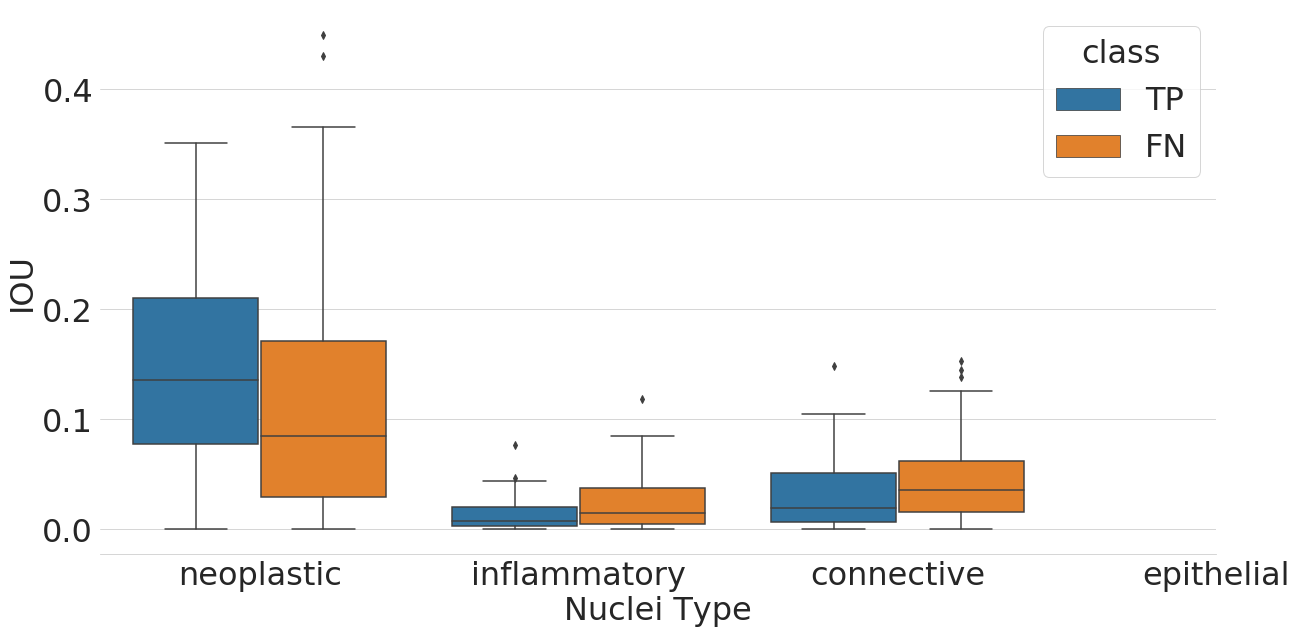

In [123]:
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams['font.size']=32

import seaborn as sns
g=sns.boxplot(data=ious_df, x="nuclei_type", y='iou', hue='class')#, orient="h")#,
               #split=True)#,cut=0) #inner="quart", linewidth=1,)
               #palette={"Yes": "b", "No": ".85"})
#
sns.despine(left=True)
g.set_xticks(range(4)) # <--- set the ticks first
g.set_xticklabels(['neoplastic', 'inflammatory', 'connective', 'epithelial'])
g.set_xlabel('Nuclei Type')
g.set_ylabel('IOU')

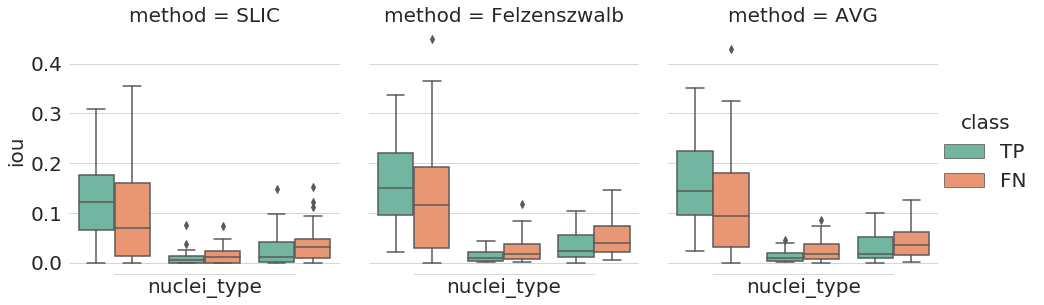

In [124]:
plt.rcParams['figure.figsize']=(20,10)
plt.rcParams['font.size']=20

import seaborn as sns
sns.set_style('whitegrid')
g=sns.catplot(data=ious_df, x="nuclei_type", y='iou', hue='class', col='method', 
              kind='box',
              palette="Set2", aspect=.9)
#
sns.despine(left=True, trim=True)



#g.set_xticks(range(4)) # <--- set the ticks first
#g.set_xticklabels(['neoplastic', 'inflammatory', 'connective', 'epithelial'])
#g.set_xlabel('Nuclei Type')
#catplot set ticks
g.set(xticks=[])
#g.set_ylabel('IOU')


### Structural Similarity SSIM between CAM and gradCAM

In [ ]:
import heatmaps_utils
reload (heatmaps_utils)
from heatmaps_utils import *

In [143]:
hmore=np.load('results/pannuke_iou_CAM_test/heatmaps_100tumor_100normal_100.npy')

In [145]:
hmore[0].keys()

['gradCAM++',
 'CAMs',
 'pred',
 'gradCAM',
 'mask',
 'CAM',
 'path',
 'type',
 'original']

In [ ]:
for i in range(len(hmore)):
    

In [136]:
prop = 0.8
h = copy.deepcopy(heatmaps_list)
np.random.shuffle(h)
h = [_h for _h in h ]#if not np.isnan(np.sum(_h['gradCAM']))]
n = int(prop*len(h))
train_list = h[:n]
test_list = h[n:]

In [ ]:
configs['vmins']

In [149]:
global vmins_dic
vmins_dic={}
global vmaxs_dic
vmaxs_dic={}
vmins_dic['SLIC']=configs['vmins'][0]
vmins_dic['Felzenszwalb']=configs['vmins'][1]
vmaxs_dic['SLIC']=configs['vmaxs'][0]
vmaxs_dic['Felzenszwalb']=configs['vmaxs'][1]
vmins_dic['CAM']=-3.783657
vmins_dic['gradCAM']=0
vmaxs_dic['gradCAM']=0.39689037

In [150]:
##SSIM between CAM and gradCAM
def compute_ssim(heatmaps, method1, method2, vmins={}, vmaxs={}):
    
    h1 = normalize_heatmap(np.asarray(heatmaps[method1], dtype=np.float64), vmin=vmins[method1], vmax=vmaxs[method1])
    h2 = normalize_heatmap(np.asarray(heatmaps[method2], dtype=np.float64), vmin=vmins[method2], vmax=vmaxs[method2])
    return ssim(h1, h2)

def compute_ssims_stats(heatmaps_list, max_=2, method1='SLIC', method2='Felzenszwalb'):
    preds=[]
    ssims = []
    
    for heatmaps in heatmaps_list[:max_]:
        #print heatmaps['path']
        #print 'pred:', heatmaps['pred']
        try:
            #auprcs, thresholds = auprc_heatmaps(heatmaps, method1, method2)
            _ssim = compute_ssim(heatmaps, method1, method2, vmins_dic, vmaxs_dic)
            preds.append(heatmaps['pred'])
            ssims.append(_ssim)
            #print 'SSIM: ', _ssim
            #for _auprc, threshold in zip(auprcs, thresholds):
            #    print round(threshold, 3), _auprc
        except Exception as e:
            print e
        #print '\n\n'
    #print 'Avg SSIMS: ', np.mean(ssims), np.std(ssims)
    return ssims, preds

In [151]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko, max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko, max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

TN (0, 0): 0.575000491897 (0.0838735192015)
FP (0, 1): 0.581347260097 (0.104863569925)
TP (1, 1): 0.584756996706 (0.0738334066967)
FN (1, 0): 0.605993759884 (0.0790431766574)


In [152]:
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ok, method1='SLIC', method2='CAM', max_=200)
print "TN (0, 0): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_normal_list_pred_ko, method1='SLIC', method2='CAM', max_=200)
print "FP (0, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ok, method1='SLIC', method2='CAM', max_=200)
print "TP (1, 1): {} ({})".format(np.mean(ssims), np.std(ssims))
ssims, preds = compute_ssims_stats(heatmaps_tumor_list_pred_ko, method1='SLIC', method2='CAM', max_=200)
print "FN (1, 0): {} ({})".format(np.mean(ssims), np.std(ssims))

'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
TN (0, 0): nan (nan)
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
FP (0, 1): nan (nan)
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
TP (1, 1): nan (nan)
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'CAM'
'

In [138]:
## btween ssim and prediction when we use cam and gradcam
# there seems to be a linear correlation between the ssim of cam/gradcam and the prediction
# high ssim if prediction is high (close to 1= tumor class)... same stuff seems to be highlighted in tumor images? check with visualiz. 
# ADD check of correctness of prediction
import statsmodels.api as sm

def linear_regression(y, X, random_state=1234, verbose=0, summary=False):
    X = sm.add_constant(X) # Add constant term
    model = sm.OLS(y, X).fit()
    if summary:
        print model.summary()
    return model

y = np.array(preds, dtype=np.float64)
X = np.array(ssims, dtype=np.float64)
lr = linear_regression(y, X)


test_pred = [heatmaps['pred'] for heatmaps in test_list]
test_ssims = [compute_ssim(heatmaps, 'SLIC', 'Felzenszwalb', vmins_dic, vmaxs_dic) for heatmaps in test_list]


X = np.array(test_pred, dtype=np.float64)
X = sm.add_constant(X) # Add constant term
params = lr.params
test_ssims_pred = np.dot(X, np.array(params))

SSE = np.sum(np.square(np.subtract(test_ssims, test_ssims_pred)))
MSE = SSE/len(test_ssims)
TSS = np.sum(np.square(np.subtract(test_ssims, np.mean(test_ssims))))
R2 = 1 - (SSE/TSS)
print MSE, R2, (SSE/TSS), lr.params

0.043028758321648396 -4.4331114225671495 5.4331114225671495 [0.76547713 0.00461217]


In [140]:
from scipy.stats import pearsonr

y = np.array(preds, dtype=np.float64)
X = np.array(ssims, dtype=np.float64)
print X.shape, y.shape, pearsonr(X,y[:,0])

(53,) (53, 1) (0.0032919061407644533, 0.9813359709430358)


3.1066356